**STEP 1.1) MOUNTING GOOGLE DRIVE**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**STEP 1.2) IMPORTING LIBRARIES**

In [2]:
import keras
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint
from glob import glob
import matplotlib.pyplot as plt
from keras.utils import plot_model
import os
from pathlib import Path

**STEP 1.3) SETTING UP WORKING PLATFORM**

In [3]:
# Skip this code block if you have already cloned the github repo in your GDrive


# Change working directory to your Google Drive
os.chdir('/content/drive/MyDrive/')

# Cloning the repository in your Google Drive.
# If you are doing inference right after doing training then no need to clone as during training process, this GitHub repo is cloned.
!git clone https://github.com/malayjoshi13/TalkingHand.git

Cloning into 'TalkingHand'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 282 (delta 25), reused 31 (delta 9), pack-reused 203
Receiving objects: 100% (282/282), 155.80 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [4]:
# Change working directory to your cloned repository
os.chdir('/content/drive/MyDrive/TalkingHand/')

# STOP!!

1. Before moving ahead, go to your Google Drive. There you'll see folder named "TalkingHand" (which is cloned copy of the GitHub repo) we are working with. <br>

2. Place the custom dataset folder (located in the local system) by the name "dataset_final" in this folder of "TalkingHand" at your Google Drive.<br>

3. Now lets's move to training process below.

**STEP 1.3) SCRIPTING THE FLOW FOR TRAINING AND VALIDATION DATASET IN BATCHED FORMAT**

In [7]:
# Here we apply data augmentation on training and testing dataset by distorting them a little bit. This improve accuracy as model is able to see different variations thus better ability to generalise
# what it has memorized rather than just mugging up.
training_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

# Next we initiaite data generators which will divide whole training and validation datasets in smaller batches of 8 images in each. This is helpful as it avoids all images to get loaded on RAM at once.
batch_size = 32

training_batched_dataset = training_datagen.flow_from_directory('final_dataset/train',
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

validation_batched_dataset = validation_datagen.flow_from_directory('final_dataset/validation',
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 2296 images belonging to 6 classes.
Found 1720 images belonging to 6 classes.


**STEP 1.4) CREATING ARCHITECTURE OF MODEL TO BE TRAINED**

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

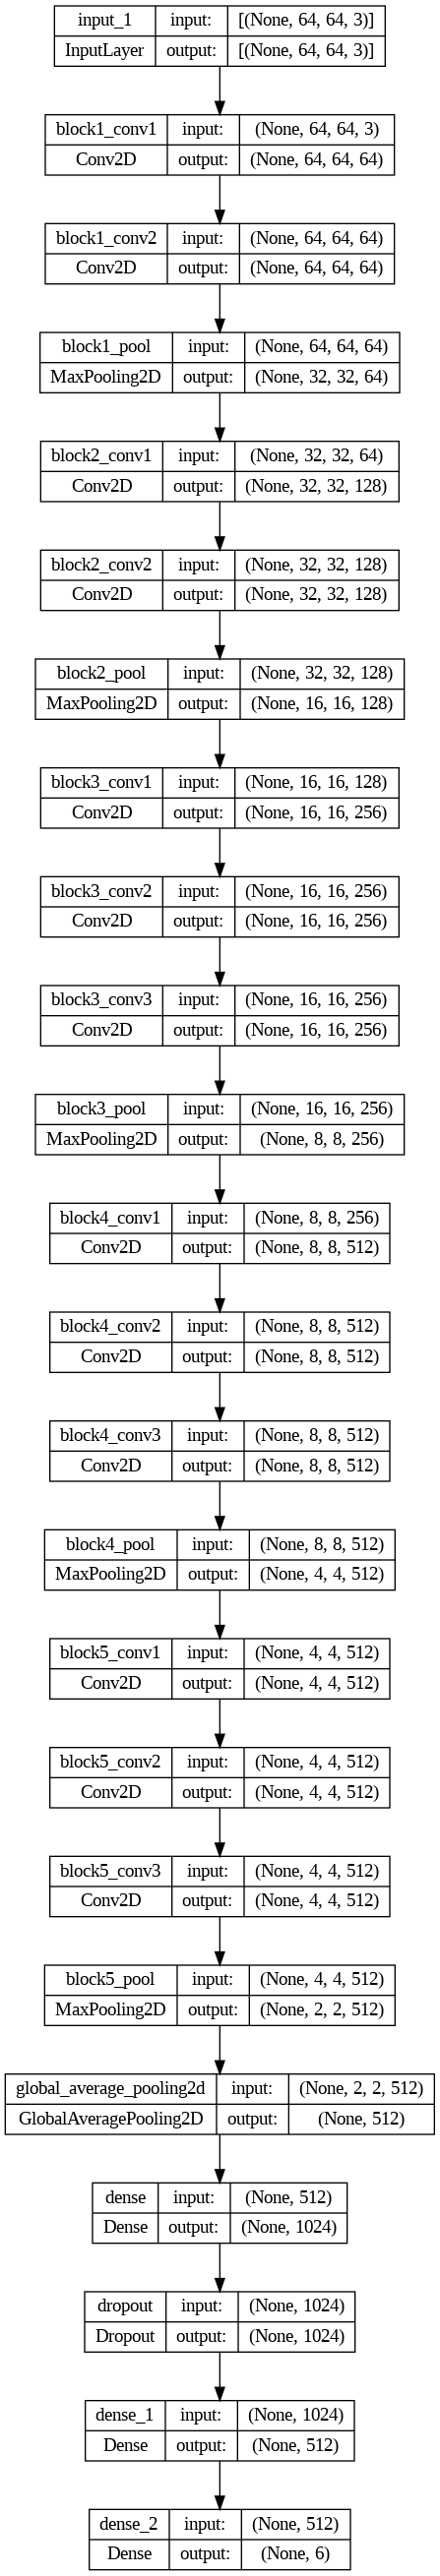

In [8]:
# Now we call VGG16 network. Then we set size of images which input layer of VGG16 accepts as the size of our training images. In this way prepare VGG16 to accept our training images as input.
# Next we set weight of VGG16 model as weight which was obtained by training this network on Imagenet dataset. We did this to avoid situation where weights would have initialised by some random value and then
# it would take long time for model to fit itself on our custom made dataset. Imagenet weights are good base to start training the network.
# WE also set “include_top” argument to False. By doing this the fully-connected output layers of the model which are used to make predictions are not loaded, thus allowing a new output layer
# to be added and trained on our custom made dataset.

# To study more about tranfer learning and fine tuning please refer: https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
base = VGG16(input_shape=[64, 64] + [3], weights='imagenet', include_top=False)

# Now we fine-tune VGG16 architecture by training the all the layers of loaded VGG16 layers. We didn't went with just using memory stored in these layers rather we ask them to train again because
# our custom model is very different from Imagenet dataset, thus asking layers of loaded VGG16 will not to anything good during prediction time.
for layer in base.layers:
  layer.trainable = True

# It is used to get number of classes/labels in our dataset.
folders = glob('final_dataset/train/*')

# We added more layers above the loaded VGG16 network to increase capacity of overall network to understand and remember features of training images.
x = base.output
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Then we create a model object, i.e. define the entrance and exit points of the complete model which is about to be trained. This complete model includes VGG16 + additional layers added on top of VGG16
model = Model(inputs=base.input, outputs=prediction)

# View the structure of the model.
# Firstly by means of:
model.summary()
# & secondly by means of:
plot_model(model, to_file='model_structure.png', show_shapes=True)

**STEP 1.5) COMPILING THE MODEL**

In [9]:
# Then we compile the model, i.e. set the parameters that keep in check how training process and backpropagation is going on
model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

**STEP 1.6) STARTING TRAINING PROCESS**

In [10]:
Path("model_weights").mkdir(parents=True, exist_ok=True)


# Now we kick start training process by setting few parameters like:
# "training_batched_dataset":- this is the path of batched training dataset coming straight from the step 1.3.
# "validation_data":- this is the path of batched validation dataset coming straight from the step 1.3.
# "epochs":- these are number of iterations/rounds for which our model will observe the whole training data. After each epoch, model on basis of its
#            observations made during that epoch, will update its weights by doing backpropagation
# "steps_per_epoch":- so these are number of steps or you say parts in which during each epoch model will see the whole dataset. So let us assume if total length of training dataset is 100 and we decide
#                     that batch_size will be "5", then for each epoch, model will see the whole dataset of 100 images, in 20 parts/steps (=100/5 = steps_per_epoch = (training_batched_dataset.samples)//batch_size)
#                     such that in each of the 20 times/steps it will see only 5 (= batch size) images out of total 100 images.
# "validation_steps":- same as above but for validation phase
# "use_multiprocessing" and "workers":- it will create batches of dataset by using CPU while in parallel GPU will do training over those batches.
#                                       Thus it will enable both CPU and GPU to keep working parallely.
# "callbacks":- using this parameter we utilised "ModelCheckpoint" functionality of Keras which enables to keep saving the weights (you can also save whole model)after each epoch based on certain
#               conditions. Like we used condition that save the whole model+weights+the compiled parameters after each epoch if and if "val_accuracy" has improvised comparitive to
#               validation accuracy of previous epoch.

# After setting all these parameters we start the training process....wohooooooo!!
r = model.fit(
  training_batched_dataset,
  validation_data=validation_batched_dataset,
  epochs=20,
  steps_per_epoch=(training_batched_dataset.samples)//batch_size,
  validation_steps=(validation_batched_dataset.samples)//batch_size,
  use_multiprocessing=True,
  workers=1,
  callbacks=[ModelCheckpoint("model_weights/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5", save_weights_only=False, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.6458 
Epoch 1: val_accuracy improved from -inf to 0.98113, saving model to model_weights/weights-01-0.9811.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 1369s 19s/step - loss: 0.8846 - accuracy: 0.6458 - val_loss: 0.0993 - val_accuracy: 0.9811
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9377
Epoch 2: val_accuracy improved from 0.98113 to 0.98644, saving model to model_weights/weights-02-0.9864.hdf5
71/71 [==============================] - 18s 249ms/step - loss: 0.1917 - accuracy: 0.9377 - val_loss: 0.0571 - val_accuracy: 0.9864
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9678
Epoch 3: val_accuracy did not improve from 0.98644
71/71 [==============================] - 16s 230ms/step - loss: 0.0888 - accuracy: 0.9678 - val_loss: 0.0703 - val_accuracy: 0.9858
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9828
Epoch 4: val_accuracy did not improve from 0.98644
71/71 [==============================] - 16s 225ms/step - loss: 0.0529 - accuracy: 0.9828 - val_loss: 0.1818 - 

**STEP 1.7) PLOTTING LOSS AND ACCURACIES CURVES**

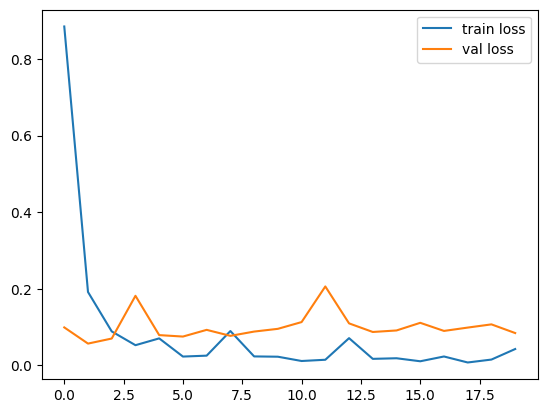

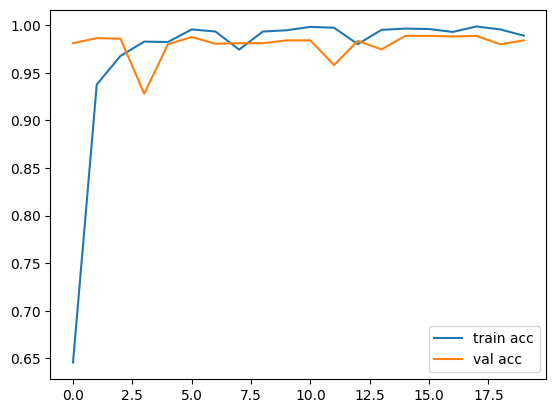

<Figure size 640x480 with 0 Axes>

In [11]:
# Then we plot loss curves
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# and accuracies curves
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')